In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import chisquare
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

__author__ = 'HK Dambanemuya'
__version__ = 'Python 3'


Bad key text.latex.preview in file /usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when

## Global Variables

In [2]:
# List of attention check columns
attention_checks = {'caddies': ['C1-Pi1', 'C1-Pi2','C2-Pi1', 'C2-Pi2',
                                'C1-Pi3', 'C1-Pi4','C2-Pi3', 'C2-Pi4'],
                    'home':    ['H1-Pi1', 'H1-Pi2','H2-Pi1', 'H2-Pi2',
                                'H1-Pi3', 'H1-Pi4','H2-Pi3', 'H2-Pi4'],
                    'ppe':     ['P1-Pi1', 'P1-Pi2','P2-Pi1', 'P2-Pi2',
                                'P1-Pi3', 'P1-Pi4','P2-Pi3', 'P2-Pi4'],
                    'stem':    ['S1-Pi1', 'S1-Pi2','S2-Pi1', 'S2-Pi2',
                                'S1-Pi3', 'S1-Pi4','S2-Pi3', 'S2-Pi4'],
                    'other':   ['D3.1', 'D4.1']}

amounts_raised_map = {"C": '40000',
                      "P": '8000',
                      "H": '4000',
                      "S": '4000'}

fundraising_goal_map = {"C": '50000',
                        "P": '10000',
                        "H": '5000',
                        "S": '5000'}

treatment_keys = {'HH': 2,
                 'H': 1,
                 'HL': 0,
                 'LH': 0,
                 'L': -1,
                 'LL':-2}

interest_values_map = {'Extremely interested': 3,
                       'Somewhat interested': 2,
                       'Not at all interested':1
                      } 

interest_map = {"C":    'I1',
                "P":    'l2',
                "Home": 'l3',
                "S":    'l4'}

altruism_values_map = {'Never': 0, 
                       'Once': 1, 
                       'More than once': 2, 
                       'Often': 3, 
                       'Very often': 4}

ssi_values_map = {'Strongly disagree': 0, 
                  'Somewhat disagree': 1, 
                  'Neither agree nor disagree': 2,
                  'Somewhat agree': 3, 
                  'Strongly agree': 4}

gender_map = {'Male': 1,
              'Female':2} # 0 = other (reference)

age_map = {'19-29 years': 0, # reference
           '30-49 years': 1,
           '50-64 years': 2,
           'Above 65 years': 3}

employment_map = {'Other, please specify ': 0, # reference
                  'Student ': 1,
                  'Seeking opportunities  ': 2,
                  'Employed Part-Time': 3,
                  'Employed Full-Time ': 4,
                  'Retired ': 5}

education_map = {'Less than high school': 0, # reference
                 'High school graduate': 1,
                 'Some college': 2,
                 'Vocational/Trade/Technical School': 3,
                 'Bachelor’s degree': 4,
                 'Advanced degree': 5}

income_map = {'Less than $15,000': 0, # reference
              '$15,000-$29,999': 1,
              '$30,000-$49,999': 2,
              '$50,000-$74,999': 3,
              '$75,000-$99,999': 4,
              'More than $100,000': 5}

race_map = {'Other ': 0, # reference
            'Asian': 1,
            'White': 2,
            'American Indian or Alaskan Native': 3,
            'Black or African American': 4}

condition_map = {'H':1,
                 'L':0}

category_map = {'C':0,
                'Home':1,
                'P':2,
                'S':3}

colors = ['red', 'grey', 'blue']

outcome_labels = ['Low', 'Both', 'High']

selection_map = {}

analysis_map = {}

baseline_preference_map = {}

## Methods

In [3]:
def ctrl_pair_summary(category, control_df):
    '''
        Method to show how many times each control pair
        is shown to participants
    '''
    pairs = []
    combinations = control_df.columns[35:41]
    for i in range(len(control_df)-1):
        pair = (list(control_df[i:i+1].dropna(axis=1).columns.intersection(combinations)))
        for j in pair:
            pairs.append(j)

    print (f"{category}: Count of Pairs Shown to Participants:\n{'--'*25}")
    print (Counter(pairs))
    print ('\n')

In [4]:
def ctrl_analysis(category, control_df):
    '''
        Method to show control project preferences
    '''
    occurrences = [] # list of project occurrences in all pair-wise comparisons
    project_a = []
    project_b = []
    selected_projects = [] # list of project selections in all pair-wise comparisons
    response_ids = []
    combinations = control_df.columns[35:41]
    
    # Iterate through all control entries
    for i in range(len(control_df)-1):  
        # Record the pair of projects that are being compared
        project_pairs = list(control_df[i:i+1].dropna(axis=1).columns.intersection(combinations))
        response_id = control_df[i:i+1]['ResponseId'].values[0]
        response_ids.append(response_id)
        if len(project_pairs) ==2:
            # For each pair-wise comparison, record user's project selection
            user_selections = [control_df[i:i+1][project_pairs[0]].values[0], control_df[i:i+1][project_pairs[1]].values[0]]
            # Iterate through the 2 project pair comparisons
            for j in [0,1]:
                
                # Split the text of the pair-wise comparison
                text = project_pairs[j].split('#')
                
                # Add selected project to list
                selected = user_selections[j]
                if selected == "Contribution List 2":
                    selected_projects.append(f'Project {text[2]}')
                else:
                    selected_projects.append(selected)
                
                # Update occurences and project lists
                occurrences.append(f'Project {text[1]}')
                project_a.append(f'Project {text[1]}')
                occurrences.append(f'Project {text[2]}')
                project_b.append(f'Project {text[2]}')
    
    print (f"{category}\n{'--'*25}")

    outcomes = []

    # {Project: Number of times that the project is selected by users}
    selected_dict = dict(Counter(selected_projects))

    # {Project: Number of times that the project is shown to users}
    occurrences_dict = dict(Counter(occurrences))

    # {Project: Percent of times that a project is selected by users}
    frequency_dict = ({k: float(selected_dict[k])/occurrences_dict[k] for k in selected_dict})
    
    for i in sorted (frequency_dict.keys()) :  
        outcomes.append(frequency_dict.get(i))
        print ("{0} was selected {1} times out of {2} = {3}%".format(i, 
                                                                     selected_dict.get(i),
                                                                     occurrences_dict.get(i),
                                                                     round(frequency_dict.get(i)*100,1)))
        
        baseline_preference_map[category[0].upper()+i[-1]] = round(frequency_dict.get(i)*100,1)
    print ('\n')

In [5]:
def preprocess_tx_amounts(category, treatment_df):
    df = treatment_df
    for column in np.concatenate([attention_checks[category][4:], attention_checks['other']]):
        df[column] = df[column].astype(str).map(lambda x: x.replace('$',''))
        df[column] = df[column].astype(str).map(lambda x: x.replace(',',''))
    return df

In [6]:
def eval_num_contributors(df, i, category_code):
    num_contributors_flag = 0
    
    try:
        num_contributors_1 = df[i:i+1][f"{category_code[0]}1-Pi1"].values[0]
    except:
        num_contributors_1 = 'not_specified'
        
    try:
        num_contributors_2 = df[i:i+1][f"{category_code[0]}2-Pi1"].values[0]
    except:
        num_contributors_2 = 'not_specified'
        
    if (num_contributors_1 == '4 most recent contributors') or (num_contributors_2 == '4 most recent contributors'):
        num_contributors_flag = 1
        
    return num_contributors_flag

In [7]:
def eval_amount_raised(df, i, category_code):
    amount_raised_flag = 0
    
    try:
        amount_raised_1 = df[i:i+1][f"{category_code[0]}1-Pi3"].values[0]
    except:
        amout_raised_1='not_specified'
    try:
        amount_raised_2 = df[i:i+1][f"{category_code[0]}2-Pi3"].values[0]
    except:
        amout_raised_2='not_specified'
              
    if (amount_raised_1 == amounts_raised_map.get(f"{category_code[0]}")) or (amount_raised_2 == amounts_raised_map.get(f"{category_code[0]}")):
        amount_raised_flag = 1
        
    return amount_raised_flag
    

In [8]:
def eval_fundraising_goal(df, i, category_code):
    fundraising_goal_flag = 0
    
    try:
        fundraising_goal_1 = df[i:i+1][f"{category_code[0]}1-Pi4"].values[0]
    except:
        fundraising_goal_1 ='not_specified'
    try:
        fundraising_goal_2 = df[i:i+1][f"{category_code[0]}2-Pi4"].values[0]
    except:
        fundraising_goal_2 ='not_specified'
        
    if (fundraising_goal_1 == fundraising_goal_map.get(f"{category_code[0]}")) or (fundraising_goal_2 == fundraising_goal_map.get(f"{category_code[0]}")):
        fundraising_goal_flag = 1
        
    return fundraising_goal_flag

In [9]:
def get_altruism_score(arr):
    return sum([altruism_values_map.get(i) for i in arr])

In [10]:
def get_ssi_score(arr):
    return sum([ssi_values_map.get(i) for i in arr])

## Import Data

In [11]:
surveys = {'caddies': pd.read_csv('caddies.csv'),
           'home': pd.read_csv('home.csv'),
           'ppe': pd.read_csv('ppe.csv'),
           'stem': pd.read_csv('stem.csv')
          }

treatment_map = {}

control_map = {}

for k in sorted(surveys.keys()):
    # Pre-process dataframe columns
    surveys[k].drop([0,1], inplace=True)
    
    # Create dataframe variable
    survey = surveys[k]
   
    # Manipulate dataframe variable
    survey['Finished'] = survey['Finished'].replace('TRUE', 'True')
    survey = survey[survey['Finished']=='True']
    
    # Assign manipulated dataframe to dict
    surveys[k] = survey
    
    # Update Treatment Map
    treatment_map[k] = survey[survey['category']=='T']
    # Update Control Map
    control_map[k] = survey[survey['category']=='C']
    # Summary Report
    print (f"{k}: {Counter(surveys[k]['category'])['T']} treatment, {Counter(surveys[k]['category'])['C']} control, {len(surveys[k])} records, {len(surveys[k].columns)} columns")


caddies: 96 treatment, 73 control, 169 records, 121 columns
home: 124 treatment, 54 control, 178 records, 121 columns
ppe: 137 treatment, 51 control, 188 records, 121 columns
stem: 105 treatment, 50 control, 155 records, 121 columns


In [12]:
familiarity_df = pd.DataFrame()
s3,s4 = [],[]
for k in surveys.keys():
    for value in surveys.get(k)['S3'].values:
        s3.append(value)
    for value in surveys.get(k)['S4'].values:
        s4.append(value)
    
familiarity_df['S3'] = s3
familiarity_df['S4'] = s4
familiarity_df['S3'].value_counts(), familiarity_df['S4'].value_counts()

(A few times per year     434
 Never                    105
 At least once a month    89 
 At least once a week     36 
 Daily                    26 
 Name: S3, dtype: int64,
 Contributor                    474
 Neither                        92 
 All of the above               73 
 Project creator/ fundraiser    51 
 Name: S4, dtype: int64)

In [13]:
dfs = []

for k,v in control_map.items():
    dfs.append(v)
c_cf = pd.concat(dfs)
c_cf = c_cf[['MTurkCode', 'D1', 'D2', 'D3', 'D4', 'D5', 'D7']]
c_cf = c_cf.rename(columns = {'MTurkCode': 'ID',
                              'D1': 'Gender',
                              'D2': 'Age',
                              'D3': 'Employment',
                              'D4': 'Education',
                              'D5': 'Income',
                              'D7': 'Race'})
c_cf['Treatment'] = [-9]*len(c_cf)
c_cf['Al_Score'] = [-9]*len(c_cf)
c_cf['SSI_Score'] = [-9]*len(c_cf)
c_cf.head()

,ID,Gender,Age,Employment,Education,Income,Race,Treatment,Al_Score,SSI_Score
2,51284,Male,19-29 years,Seeking opportunities,Bachelor’s degree,"$15,000-$29,999",Black or African American,-9,-9,-9
3,10241,Non Binary,30-49 years,Employed Full-Time,Bachelor’s degree,"$50,000-$74,999",American Indian or Alaskan Native,-9,-9,-9
4,15693,Female,30-49 years,Employed Part-Time,Bachelor’s degree,"$50,000-$74,999",White,-9,-9,-9
6,81209,Male,30-49 years,Employed Full-Time,Bachelor’s degree,"$50,000-$74,999",White,-9,-9,-9
8,79639,Female,19-29 years,Employed Full-Time,Bachelor’s degree,"$75,000-$99,999",White,-9,-9,-9


## Control Analysis

In [14]:
for category, control_df in control_map.items():
    ctrl_pair_summary(category, control_df)

caddies: Count of Pairs Shown to Participants:
--------------------------------------------------
Counter({'ctl #3#4': 25, 'ctl #1#2': 25, 'ctl #1#4': 25, 'ctl #2#3': 25, 'ctl #3#1': 22, 'ctl #4#2': 22})


home: Count of Pairs Shown to Participants:
--------------------------------------------------
Counter({'ctl #2#3': 18, 'ctl #1#4': 18, 'ctl #3#1': 18, 'ctl #4#2': 18, 'ctl #1#2': 17, 'ctl #3#4': 17})


ppe: Count of Pairs Shown to Participants:
--------------------------------------------------
Counter({'ctl #3#4': 17, 'ctl #1#2': 17, 'ctl #4#2': 17, 'ctl #3#1': 17, 'ctl #1#4': 16, 'ctl #2#3': 16})


stem: Count of Pairs Shown to Participants:
--------------------------------------------------
Counter({'ctl #3#4': 18, 'ctl #1#2': 18, 'ctl #4#2': 16, 'ctl #3#1': 16, 'ctl #2#3': 15, 'ctl #1#4': 15})




In [15]:
for category, control_df in control_map.items():
    ctrl_analysis(category, control_df)          

caddies
--------------------------------------------------
Project 1 was selected 42 times out of 72 = 58.3%
Project 2 was selected 33 times out of 72 = 45.8%
Project 3 was selected 22 times out of 72 = 30.6%
Project 4 was selected 47 times out of 72 = 65.3%


home
--------------------------------------------------
Project 1 was selected 27 times out of 53 = 50.9%
Project 2 was selected 33 times out of 53 = 62.3%
Project 3 was selected 22 times out of 53 = 41.5%
Project 4 was selected 24 times out of 53 = 45.3%


ppe
--------------------------------------------------
Project 1 was selected 24 times out of 50 = 48.0%
Project 2 was selected 23 times out of 50 = 46.0%
Project 3 was selected 27 times out of 50 = 54.0%
Project 4 was selected 26 times out of 50 = 52.0%


stem
--------------------------------------------------
Project 1 was selected 22 times out of 49 = 44.9%
Project 2 was selected 32 times out of 49 = 65.3%
Project 3 was selected 27 times out of 49 = 55.1%
Project 4 was sele

In [16]:
c_list = pd.Series([58.3, 45.8, 30.6, 65.3, 50.9, 62.3, 41.5, 45.3, 48, 46, 54, 52, 44.9, 65.3, 55.1, 34.7])
c_list.describe()

count   16.000
mean    50.000
std     10.012
min     30.600
25%     45.200
50%     49.450
75%     55.900
max     65.300
dtype: float64

In [17]:
baseline_preference_map

{'C1': 58.3,
 'C2': 45.8,
 'C3': 30.6,
 'C4': 65.3,
 'H1': 50.9,
 'H2': 62.3,
 'H3': 41.5,
 'H4': 45.3,
 'P1': 48.0,
 'P2': 46.0,
 'P3': 54.0,
 'P4': 52.0,
 'S1': 44.9,
 'S2': 65.3,
 'S3': 55.1,
 'S4': 34.7}

## Treatment Analysis

In [18]:
# pre-process treatment_df amount columns
for category,treatment_df in treatment_map.items():
    treatment_map[category] = preprocess_tx_amounts(category, treatment_map[category])

In [23]:
reasons, alt, ints, si = [], [], [], []
for category in sorted(list(treatment_map.keys())): # TODO: Change to method signature
    comparison_columns = list(set(treatment_map[category].columns[46:78])-set(attention_checks[category]))
    comparison_df = treatment_map[category][comparison_columns]
    
    # Computed variables
    proj_codes, proj_nums, proj_conds, sel_codes = [], [], [], []
    # Experiment variables
    interest, ssi, altruism = [], [], []
    # Demographic variables
    gender, age, employment, education, income, race = [], [], [], [], [], []
    # Baseline preference
    baseline = []
    
    analysis_df = pd.DataFrame()
    analysis_df['ID'] = treatment_map[category]['MTurkCode']
    analysis_df['Gender'] = treatment_map[category]['D1']
    analysis_df['Age'] = treatment_map[category]['D2']
    analysis_df['Employment'] = treatment_map[category]['D3']
    analysis_df['Education'] = treatment_map[category]['D4']
    analysis_df['Income'] = treatment_map[category]['D5']
    analysis_df['Race'] = treatment_map[category]['D7']
    
    
    
    # For each row in comparison dataframe
    for i in  range(len(comparison_df)): 
        # Identify the pair-wise combinations shown to users
        combos = list(comparison_df[i:i+1].dropna(axis=1).columns.intersection(comparison_columns))
        # keep track of selected project
        sel_code = ""

        # Experiment Variables
        ssi_ = get_ssi_score(treatment_map[category][i:i+1][treatment_map[category].columns[100:118]].values[0])
        altruism_ = get_altruism_score(treatment_map[category][i:i+1][treatment_map[category].columns[80:100]].values[0])
        
        # For each pair-wise combination
        for idx, combo in enumerate(combos):
            # Get project category
            category_code = combo[:-6]
            # Apply attention checks
            checksum = (eval_num_contributors(treatment_map[category],i,category_code) +
                        eval_amount_raised(treatment_map[category],i,category_code) +
                        eval_fundraising_goal(treatment_map[category],i,category_code))
                        
            if checksum==3:
                #### Survey Variables ####
                
                # Reasons
                reasons.append(treatment_map[category][i:i+1][f'{category_code[0]}1-Pi2'].values[0])
                reasons.append(treatment_map[category][i:i+1][f'{category_code[0]}2-Pi2'].values[0])
                alt.append(altruism_)
                alt.append(altruism_)
                si.append(ssi_)
                si.append(ssi_)
                
                # Experiment Variables
                interest.append(treatment_map[category][i:i+1][interest_map.get(category_code)].values[0])
                ints.append(treatment_map[category][i:i+1][interest_map.get(category_code)].values[0])
                ints.append(treatment_map[category][i:i+1][interest_map.get(category_code)].values[0])
                ssi.append(ssi_)
                altruism.append(altruism_)
                # Demographic Variables
                gender.append(treatment_map[category][i:i+1]['D1'].values[0])
                age.append(treatment_map[category][i:i+1]['D2'].values[0])
                employment.append(treatment_map[category][i:i+1]['D3'].values[0])
                education.append(treatment_map[category][i:i+1]['D4'].values[0])
                income.append(treatment_map[category][i:i+1]['D5'].values[0])
                race.append(treatment_map[category][i:i+1]['D7'].values[0])
                
                #### Computed Variables ####
                
                # Get project category
                proj_codes.append(category_code)
                
                # Identify the selected project
                selected = comparison_df[i:i+1][combo].values[0]
                
                # Get project number
                proj_num = selected[-1]
                proj_nums.append(proj_num)
                
                # Get the combination code
                codes = combo[-6:]
                
                # Get treatment condition
                if codes[0] == proj_num:
                    condition = codes[2]
                    proj_conds.append(condition)
                    baseline.append(baseline_preference_map.get(category_code[0]+proj_num))
                    sel_code = sel_code+condition
                elif codes[3] == proj_num:
                    condition = codes[-1]
                    proj_conds.append(condition)
                    baseline.append(baseline_preference_map.get(category_code[0]+proj_num))
                    sel_code = sel_code+condition
                else:
                    proj_conds.append('error')
                    sel_code = sel_code+'error'
            else:
                pass
        
#         print (f"Selection Code = {sel_code}")       
        sel_codes.append(sel_code)
    assert len(proj_codes) == len(proj_nums) == len(proj_conds)
    
    treatment_map[category]['User_Selection'] = sel_codes
    # Apply attention checks to selections
    treatment_map[category] = treatment_map[category][treatment_map[category]['User_Selection']!='']
    treatment_map[category] = treatment_map[category]
    
    analysis_df['Treatment'] = sel_codes
    analysis_df = analysis_df[analysis_df['Treatment']!='']
    analysis_map[category] = analysis_df

    selection_df_ = pd.DataFrame()
#     selection_df_['Category'] = proj_codes #[category_map.get(val,-1) for val in proj_codes]
#     selection_df_['Gender'] = [gender_map.get(val,0) for val in gender]
#     selection_df_['Age'] = [age_map.get(val,-1) for val in age]
#     selection_df_['Employment'] = [employment_map.get(val,-1) for val in employment]
#     selection_df_['Education'] = [education_map.get(val,-1) for val in education]
#     selection_df_['Income'] = [income_map.get(val,-1) for val in income]
#     selection_df_['Race'] = [race_map.get(val,-1) for val in race]
#     selection_df_['Interest'] = interest
#     selection_df_['Interest'].replace(interest_values_map, inplace=True)
#     selection_df_['Baseline'] = baseline
#     selection_df_['SSI'] = ssi
#     selection_df_['Altruism'] = altruism
#     selection_df_['Treatment'] = proj_conds #[condition_map.get(val,-1) for val in proj_conds]
#     selection_map[category] = selection_df_

    selection_df_['Category'] = proj_codes #[category_map.get(val,-1) for val in proj_codes]
    selection_df_['Gender'] = gender
    selection_df_['Age'] = age
    selection_df_['Employment'] = employment
    selection_df_['Education'] = education
    selection_df_['Income'] = income
    selection_df_['Race'] = race
    selection_df_['Interest'] = interest
    selection_df_['Interest'].replace(interest_values_map, inplace=True)
    selection_df_['Baseline'] = baseline
    selection_df_['SSI'] = ssi
    selection_df_['Altruism'] = altruism
    selection_df_['Treatment'] = proj_conds #[condition_map.get(val,-1) for val in proj_conds]
    selection_map[category] = selection_df_

# Analysis DataFrame
analysis_df = pd.concat([analysis_map[k] for k in sorted(analysis_map.keys())])
analysis_df['Treatment'].replace(treatment_keys, inplace=True)

# Selection DataFrame
selection_df = pd.concat([selection_map[k] for k in sorted(selection_map.keys())])

In [24]:
selection_df

,Category,Gender,Age,Employment,Education,Income,Race,Interest,Baseline,SSI,Altruism,Treatment
0,C,Female,30-49 years,Employed Full-Time,Bachelor’s degree,"$30,000-$49,999",White,1,30.600,37,30,H
1,C,Female,30-49 years,Employed Full-Time,Bachelor’s degree,"$30,000-$49,999",White,1,45.800,37,30,L
2,C,Female,19-29 years,Seeking opportunities,Vocational/Trade/Technical School,"$30,000-$49,999",White,2,58.300,36,40,L
3,C,Female,19-29 years,Seeking opportunities,Vocational/Trade/Technical School,"$30,000-$49,999",White,2,45.800,36,40,H
4,C,Male,30-49 years,Employed Full-Time,Advanced degree,"$50,000-$74,999",White,1,58.300,34,41,H
...,...,...,...,...,...,...,...,...,...,...,...,...
177,S,Male,30-49 years,Employed Full-Time,Bachelor’s degree,"$50,000-$74,999",White,3,65.300,60,51,L
178,S,Female,30-49 years,Employed Part-Time,Some college,"More than $100,000",White,3,34.700,32,16,H
179,S,Female,30-49 years,Employed Part-Time,Some college,"More than $100,000",White,3,65.300,32,16,H
180,S,Male,30-49 years,Employed Full-Time,Bachelor’s degree,"$50,000-$74,999",White,2,65.300,53,39,L


In [25]:
selection_df[['Category', 'Treatment', 'Interest']].groupby(['Category', 'Treatment']).agg('count').reset_index().rename(columns={"Interest": "Selected"})


,Category,Treatment,Selected
0,C,H,62
1,C,L,76
2,Home,H,102
3,Home,L,83
4,P,H,56
5,P,L,54
6,S,H,102
7,S,L,80


In [26]:
selection_df[['Gender', 'Treatment', 'Interest']].groupby(['Gender', 'Treatment']).agg('count').reset_index().rename(columns={"Interest": "Selected"})


,Gender,Treatment,Selected
0,Female,H,158
1,Female,L,148
2,Male,H,159
3,Male,L,144
4,Non Binary,H,5
5,Non Binary,L,1


In [27]:
selection_df[['Age', 'Treatment', 'Interest']].groupby(['Age', 'Treatment']).agg('count').reset_index().rename(columns={"Interest": "Selected"})


,Age,Treatment,Selected
0,19-29 years,H,66
1,19-29 years,L,67
2,30-49 years,H,178
3,30-49 years,L,168
4,50-64 years,H,67
5,50-64 years,L,41
6,Above 65 years,H,11
7,Above 65 years,L,17


In [28]:
selection_df[['Employment', 'Treatment', 'Interest']].groupby(['Employment', 'Treatment']).agg('count').reset_index().rename(columns={"Interest": "Selected"})


,Employment,Treatment,Selected
0,Employed Full-Time,H,207
1,Employed Full-Time,L,189
2,Employed Part-Time,H,57
3,Employed Part-Time,L,39
4,"Other, please specify",H,14
5,"Other, please specify",L,8
6,Retired,H,8
7,Retired,L,12
8,Seeking opportunities,H,25
9,Seeking opportunities,L,25


In [29]:
selection_df[['Education', 'Treatment', 'Interest']].groupby(['Education', 'Treatment']).agg('count').reset_index().rename(columns={"Interest": "Selected"})


,Education,Treatment,Selected
0,Advanced degree,H,44
1,Advanced degree,L,52
2,Bachelor’s degree,H,170
3,Bachelor’s degree,L,134
4,High school graduate,H,26
5,High school graduate,L,24
6,Less than high school,H,3
7,Less than high school,L,1
8,Some college,H,69
9,Some college,L,76


In [30]:
selection_df[['Income', 'Treatment', 'Interest']].groupby(['Income', 'Treatment']).agg('count').reset_index().rename(columns={"Interest": "Selected"})


,Income,Treatment,Selected
0,"$15,000-$29,999",H,43
1,"$15,000-$29,999",L,29
2,"$30,000-$49,999",H,66
3,"$30,000-$49,999",L,68
4,"$50,000-$74,999",H,80
5,"$50,000-$74,999",L,71
6,"$75,000-$99,999",H,58
7,"$75,000-$99,999",L,52
8,"Less than $15,000",H,21
9,"Less than $15,000",L,25


In [31]:
selection_df[['Race', 'Treatment', 'Interest']].groupby(['Race', 'Treatment']).agg('count').reset_index().rename(columns={"Interest": "Selected"})


,Race,Treatment,Selected
0,American Indian or Alaskan Native,H,2
1,American Indian or Alaskan Native,L,2
2,Asian,H,22
3,Asian,L,18
4,Black or African American,H,41
5,Black or African American,L,27
6,Other,H,6
7,Other,L,10
8,White,H,251
9,White,L,236


In [20]:
reasons_df = pd.DataFrame()
reasons_df['Reasons'] = reasons
reasons_df['altruism'] = alt
reasons_df['ssi'] = si
reasons_df['interest'] = ints
reasons_df['interest'].replace(interest_values_map, inplace=True)
reasons_df = reasons_df.dropna()
reasons_df = reasons_df.drop_duplicates(subset='Reasons')
reasons_df.to_csv('StudyB_Values.csv', index=False)
len(reasons_df)

538

In [21]:
# reasons_v1 = pd.read_csv('StudyB_Reasons.csv')
# reasons_v2 = pd.read_csv('StudyB_Values.csv')

In [22]:
# reasons_analysis = reasons_v1.merge(reasons_v2, on='Reasons', how='left')
# reasons_analysis = reasons_analysis.fillna(0)
# reasons_analysis.to_csv('../../Data/StudyB_reason_values.csv', index=False)
# print(len(reasons_analysis))

In [23]:
selection_df.head(10)

,Category,Gender,Age,Employment,Education,Income,Race,Interest,Baseline,SSI,Altruism,Treatment
0,C,2,1,4,4,2,2,1,30.600,37,30,H
1,C,2,1,4,4,2,2,1,45.800,37,30,L
2,C,2,0,2,3,2,2,2,58.300,36,40,L
3,C,2,0,2,3,2,2,2,45.800,36,40,H
4,C,1,1,4,5,3,2,1,45.800,34,41,H
5,C,1,1,4,5,3,2,1,58.300,34,41,H
6,C,2,1,4,4,2,2,1,30.600,28,42,H
7,C,2,1,4,4,2,2,1,58.300,28,42,H
8,C,1,1,4,2,3,2,2,65.300,32,39,H
9,C,1,1,4,2,3,2,2,45.800,32,39,H


In [24]:
Counter(selection_df['Category'])

Counter({'C': 138, 'Home': 185, 'P': 110, 'S': 182})

In [25]:
selection_df[['Treatment','Category']].groupby(['Treatment']).agg('count').reset_index().rename(columns={'Category':'Count'})

,Treatment,Count
0,H,322
1,L,293


In [26]:
selection_df[['Category', 'Treatment','Interest']].groupby(['Category', 'Treatment']).agg('count').reset_index().rename(columns={'Interest':'Count'})

,Category,Treatment,Count
0,C,H,62
1,C,L,76
2,Home,H,102
3,Home,L,83
4,P,H,56
5,P,L,54
6,S,H,102
7,S,L,80


In [27]:
selection_df[['Category', 'Interest', 'SSI', 'Altruism']].groupby('Category').agg(['mean', 'std'])

Interest          SSI        Altruism       
             mean   std   mean    std     mean    std
Category                                             
C        1.565    0.627 32.652 16.274 37.130   14.238
Home     2.573    0.577 31.005 15.207 37.308   11.885
P        2.291    0.654 29.745 10.428 36.673   11.589
S        2.286    0.636 31.780 12.896 37.604   9.946

In [28]:
print (selection_df[selection_df['Category']=='C']['Interest'].mean(),
      selection_df[selection_df['Category']=='C']['Interest'].std())

print (selection_df[selection_df['Category']!='C']['Interest'].mean(),
      selection_df[selection_df['Category']!='C']['Interest'].std())

t, p_t = stats.ttest_ind(selection_df[selection_df['Category']=='C']['Interest'].values,
                        selection_df[selection_df['Category']!='C']['Interest'].values, 
                        equal_var = False)
print (t,p_t)

1.565217391304348 0.627316399279362
2.39832285115304 0.6323204203847534
-13.714988752992562 1.7705634044848563e-31


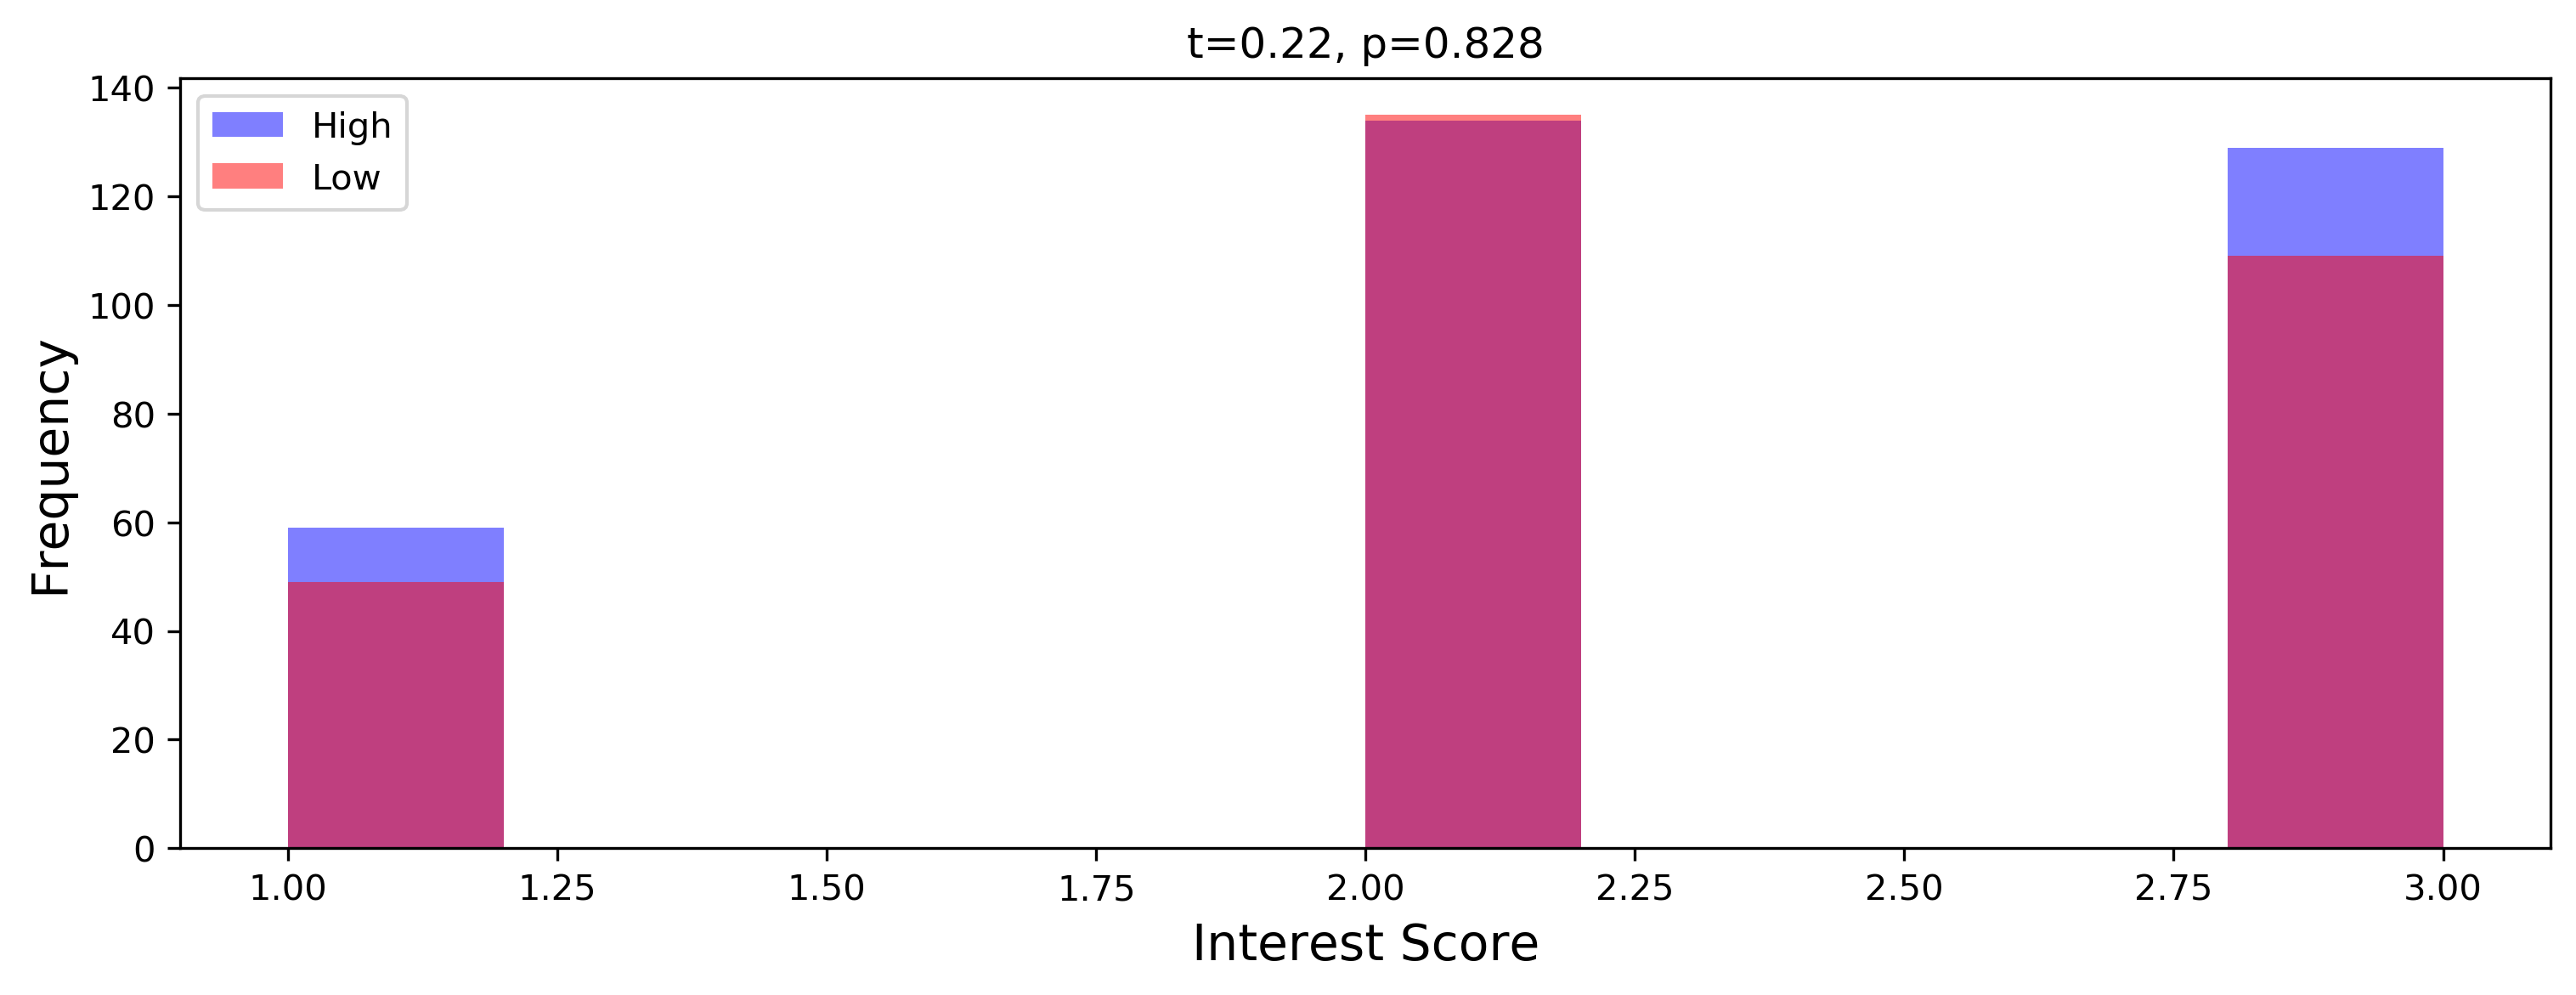

In [29]:
t, p_t = stats.ttest_ind(selection_df[selection_df['Treatment']=='H']['Interest'].values,
                        selection_df[selection_df['Treatment']=='L']['Interest'].values, 
                        equal_var = False)

fig = plt.figure(figsize=(12,4), dpi=300)
selection_df[selection_df['Treatment']=='H']['Interest'].plot(kind='hist', color='b', alpha=.5, label='High');
selection_df[selection_df['Treatment']=='L']['Interest'].plot(kind='hist', color='r', alpha=.5, label='Low');
plt.title(f"t={round(t,2)}, p={round(p_t,3)}")
plt.xlabel("Interest Score", size=14)
plt.ylabel("Frequency", size=14)
# plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [30]:
selection_df[['Treatment', 'Interest']].groupby(['Treatment']).agg('mean').reset_index().rename(columns={"Interest": "Avg Interest"})

,Treatment,Avg Interest
0,H,2.217
1,L,2.205


## Altruism

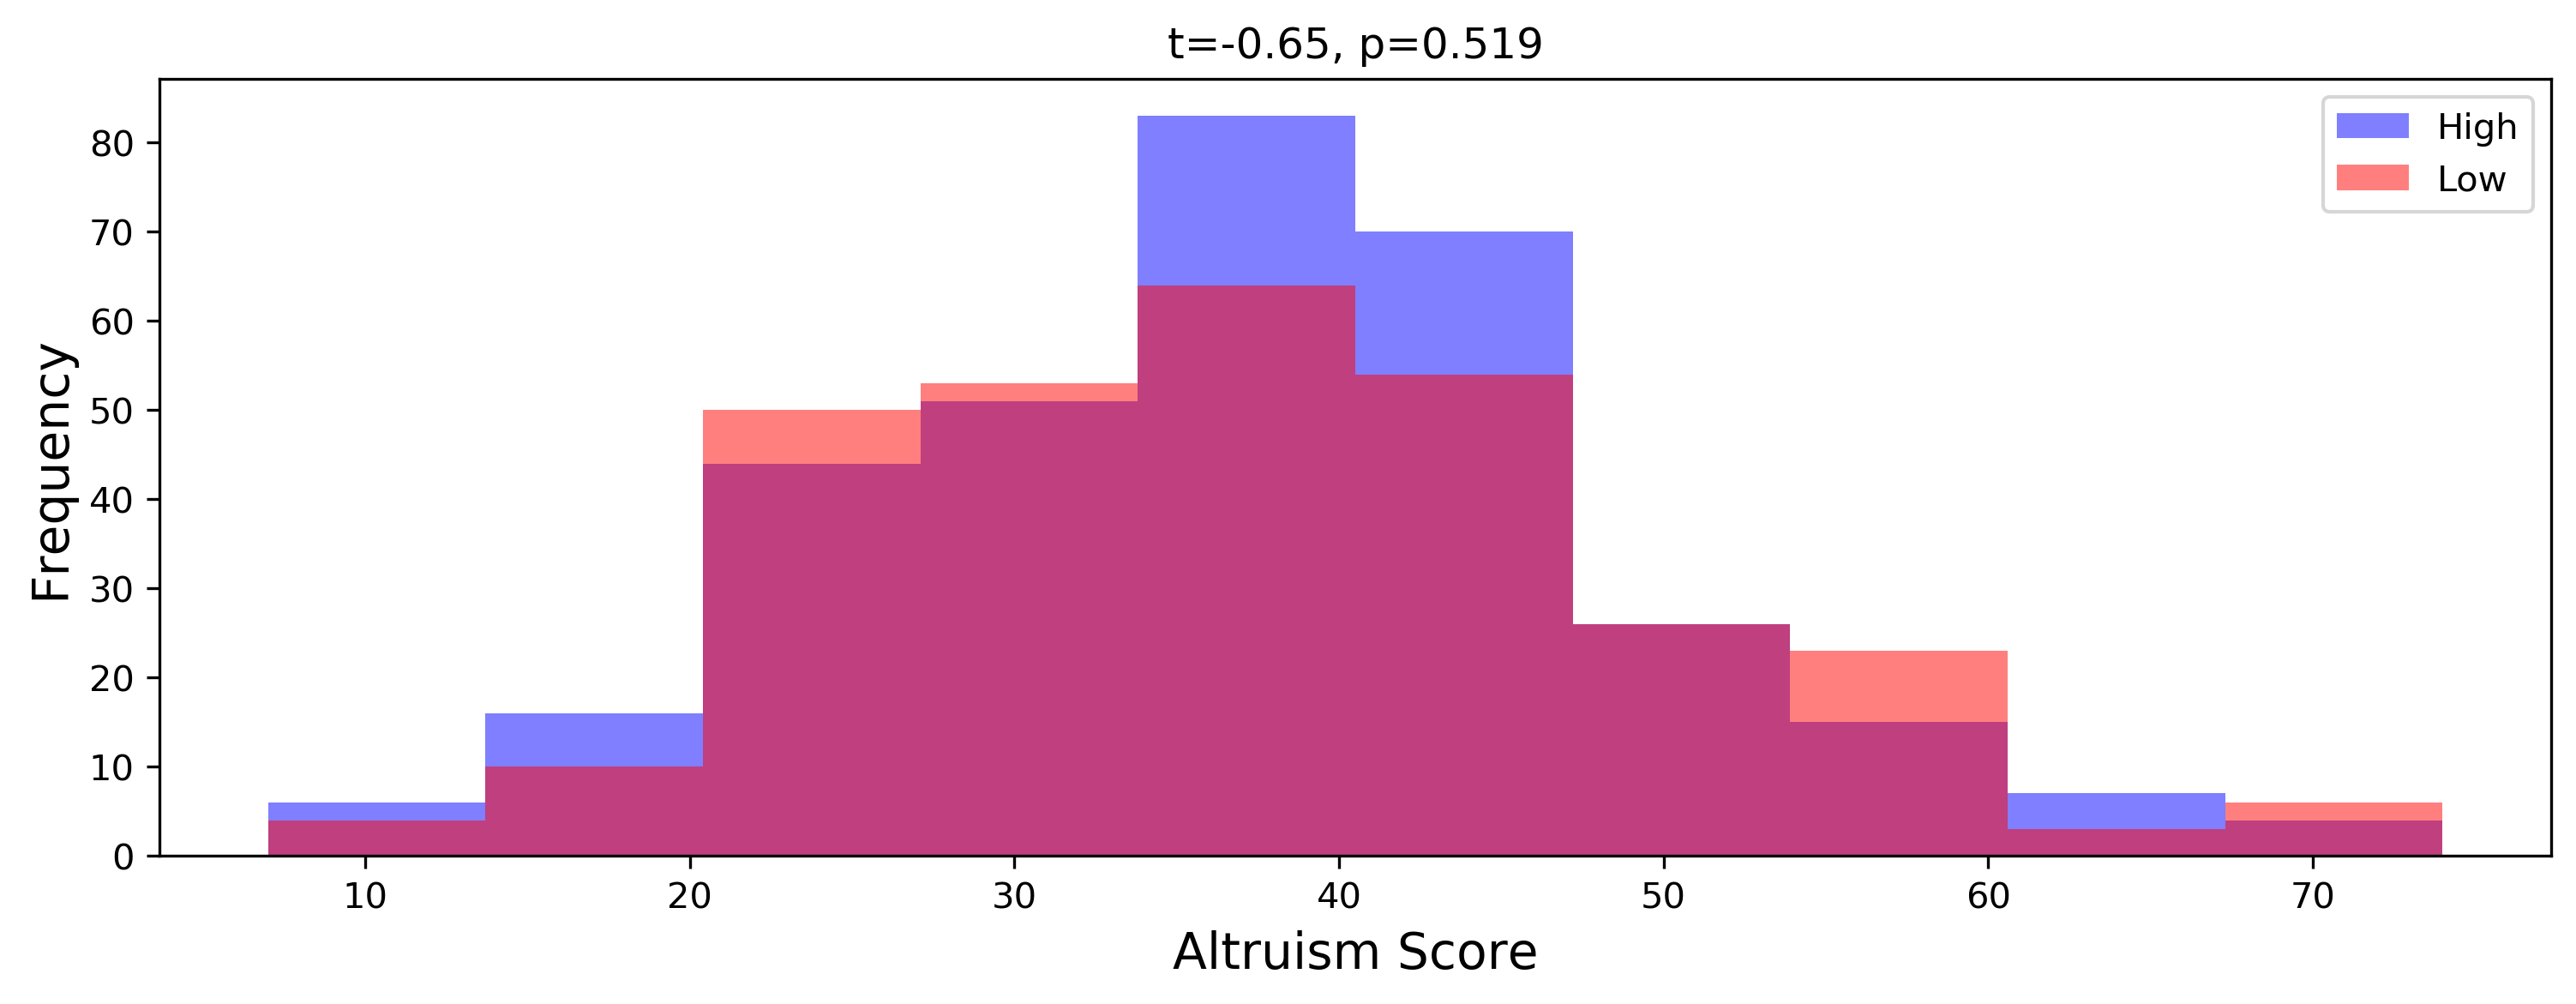

In [31]:
t, p_t = stats.ttest_ind(selection_df[selection_df['Treatment']=='H']['Altruism'].values,
                        selection_df[selection_df['Treatment']=='L']['Altruism'].values, 
                        equal_var = False)

fig = plt.figure(figsize=(12,4), dpi=300)
selection_df[selection_df['Treatment']=='H']['Altruism'].plot(kind='hist', color='b', alpha=.5, label='High');
selection_df[selection_df['Treatment']=='L']['Altruism'].plot(kind='hist', color='r', alpha=.5, label='Low');
plt.title(f"t={round(t,2)}, p={round(p_t,3)}")
plt.xlabel("Altruism Score", size=14)
plt.ylabel("Frequency", size=14)
# plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [32]:
altruism_arr = []
for category in sorted(treatment_map.keys()):
    altruism_columns = treatment_map[category].columns[80:100]
    altruism_df = treatment_map[category][altruism_columns]
    altruism_values = set(np.concatenate(treatment_map[category][altruism_columns].values))
    altruism_df.replace(altruism_values_map, inplace=True)
    altruism_arr.append(altruism_df)
altruism_df = pd.concat(altruism_arr)

var = 'Al_Score'
ov_alt = altruism_df.sum(axis=1)
altruism_df[var] = ov_alt
analysis_df[var] = ov_alt

# F, p_a = stats.f_oneway(analysis_df[(analysis_df.Treatment==-2)][var].values,
#                       analysis_df[(analysis_df.Treatment==0)][var].values,
#                       analysis_df[(analysis_df.Treatment==2)][var].values)

# fig = plt.figure(figsize=(12,4), dpi=300)
# for idx, i in enumerate([-2,0,2]):
#     sns.kdeplot(analysis_df[analysis_df['Treatment']==i][var], color=colors[idx], alpha=.75, label=outcome_labels[idx]);
#     plt.vlines(analysis_df[analysis_df['Treatment']==i][var].mean(),0,.04, color=colors[idx], alpha=.75, linestyle='--')
# plt.xlabel("Altruism Score", size=14)
# plt.ylabel("Frequency", size=14)
# plt.title(f"All participants: F={round(F,2)}, p={round(p_a,3)}")
# plt.legend();

In [33]:
analysis_df[['Treatment', 'Al_Score']].groupby(['Treatment']).agg(['count', 'mean', 'var', 'std']).reset_index().rename(columns={"Al_Score": "Avg Altruism"})

Treatment Avg Altruism                      
                   count   mean     var    std
0 -2         87          37.609 132.404 11.507
1  0         119         37.504 166.947 12.921
2  1         1           38.000 nan     nan   
3  2         101         36.614 120.379 10.972

## Social Influence

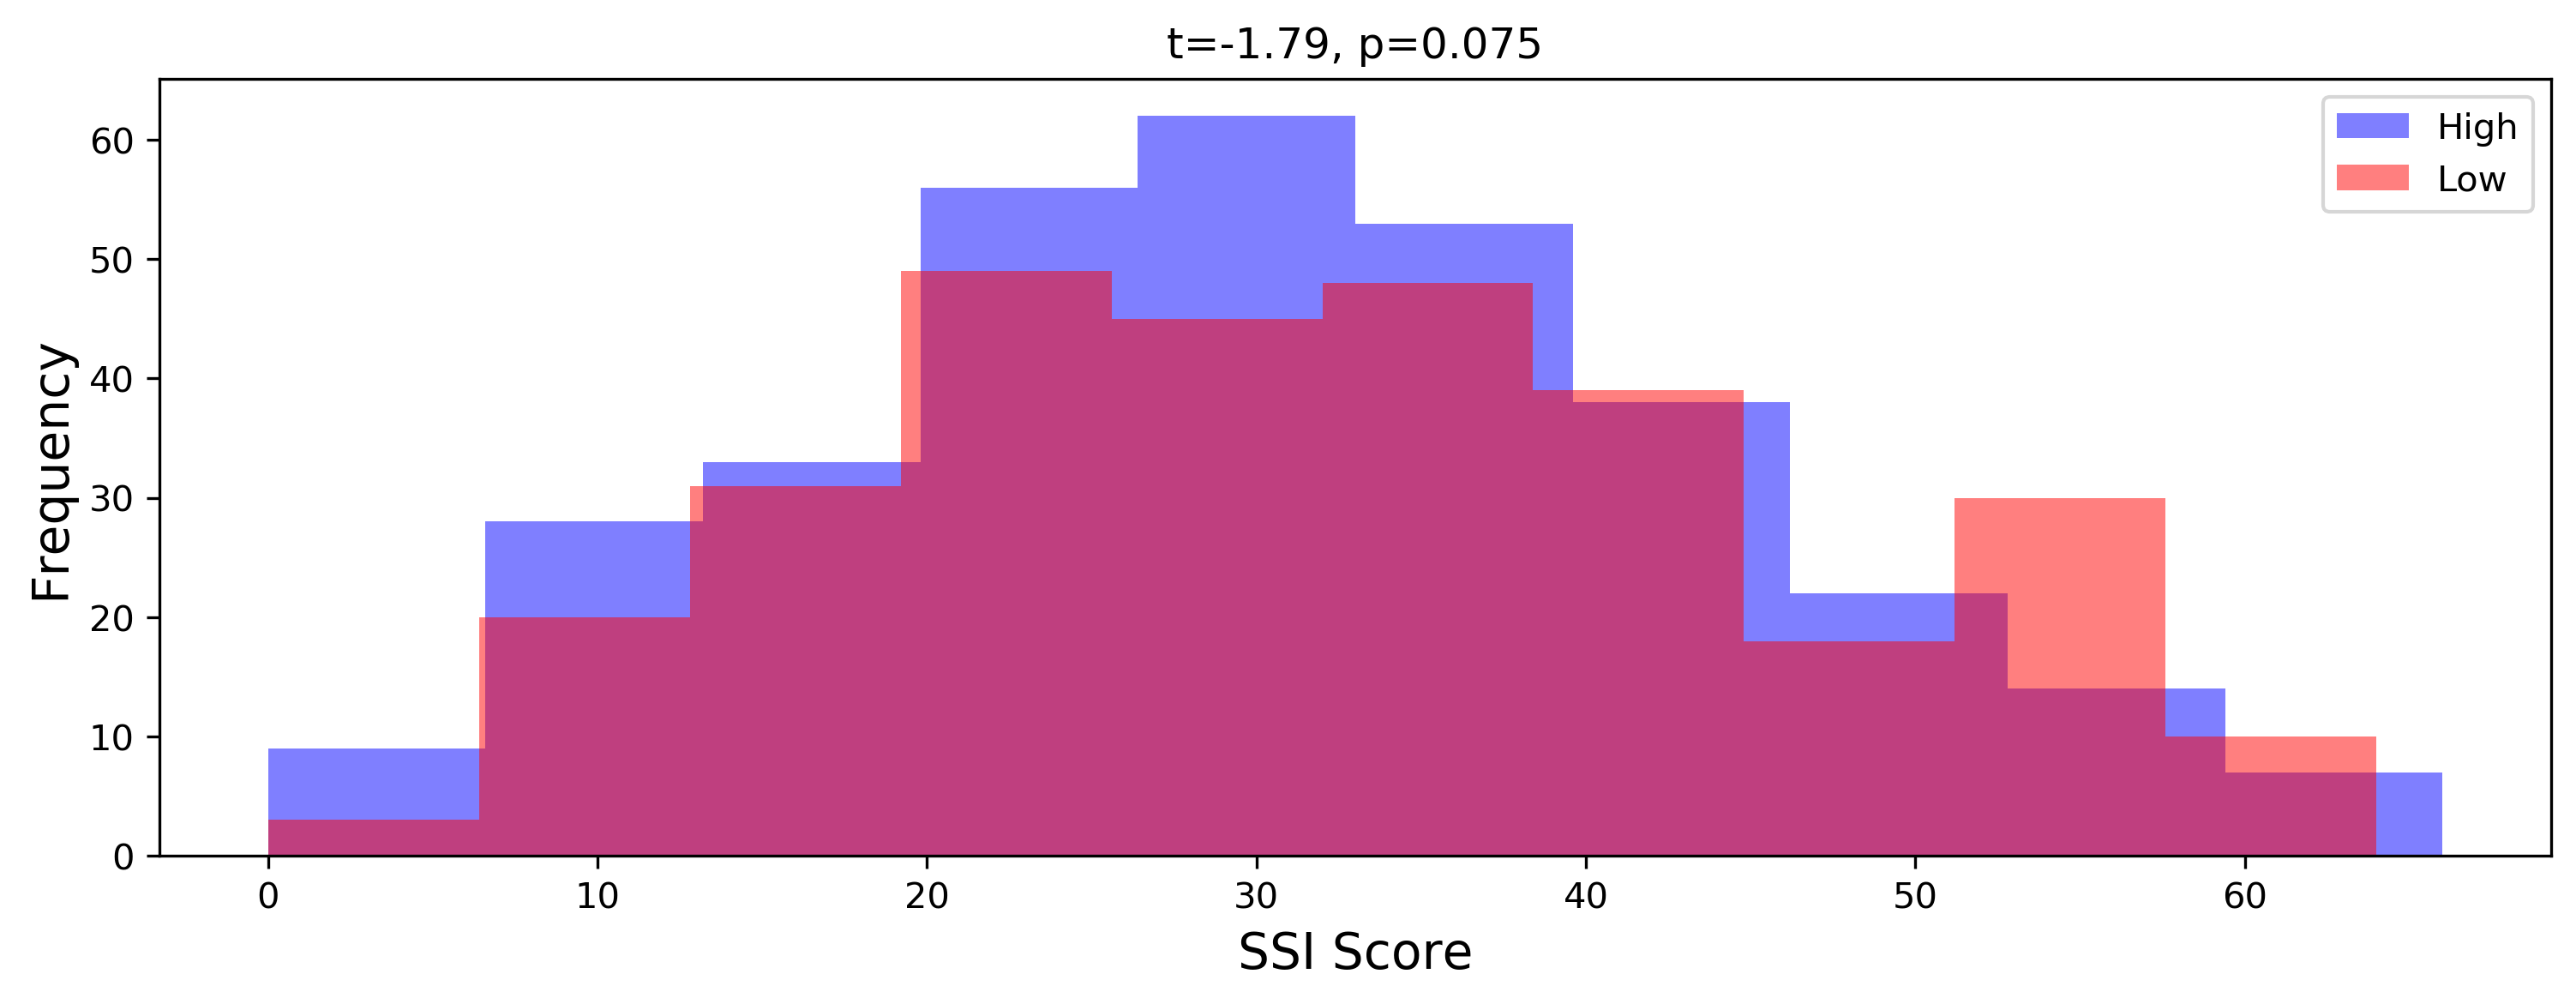

In [34]:
t, p_t = stats.ttest_ind(selection_df[selection_df['Treatment']=='H']['SSI'].values,
                        selection_df[selection_df['Treatment']=='L']['SSI'].values, 
                        equal_var = False)

fig = plt.figure(figsize=(12,4), dpi=300)
selection_df[selection_df['Treatment']=='H']['SSI'].plot(kind='hist', color='b', alpha=.5, label='High');
selection_df[selection_df['Treatment']=='L']['SSI'].plot(kind='hist', color='r', alpha=.5, label='Low');
plt.title(f"t={round(t,2)}, p={round(p_t,3)}")
plt.xlabel("SSI Score", size=14)
plt.ylabel("Frequency", size=14)
# plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [35]:
ssi_arr = []
for category in sorted(treatment_map.keys()):
    ssi_columns = treatment_map[category].columns[100:118]
    ssi_df = treatment_map[category][ssi_columns]

    ssi_values = set(np.concatenate(treatment_map[category][ssi_columns].values))

    ssi_df.replace(ssi_values_map, inplace=True)
    ssi_arr.append(ssi_df)  
ssi_df = pd.concat(ssi_arr)

var = 'SSI_Score'

ov_ssi = ssi_df.sum(axis=1)
ssi_df[var] = ov_ssi
analysis_df[var] = ov_ssi

# F, p_a = stats.f_oneway(analysis_df[(analysis_df.Treatment==-2)][var].values,
#                       analysis_df[(analysis_df.Treatment==0)][var].values,
#                       analysis_df[(analysis_df.Treatment==2)][var].values)

# fig = plt.figure(figsize=(12,4), dpi=300)
# for idx, i in enumerate([-2,0,2]):
#     sns.kdeplot(analysis_df[analysis_df['Treatment']==i][var], color=colors[idx], alpha=.75, label=outcome_labels[idx]);
#     plt.vlines(analysis_df[analysis_df['Treatment']==i][var].mean(),0,.035, color=colors[idx], alpha=.75, linestyle='--')
# plt.xlabel("Social Influence Score", size=14)
# plt.ylabel("Frequency", size=14)
# plt.title(f"F={round(F,2)}, p={round(p_a,3)}")
# plt.legend();


In [36]:
analysis_df[['Treatment', 'SSI_Score']].groupby(['Treatment']).agg(['count', 'mean', 'var', 'std']).reset_index().rename(columns={"SSI_Score": "Avg SSI"})

Treatment Avg SSI                      
              count   mean     var    std
0 -2         87     34.609 193.311 13.904
1  0         119    29.269 206.724 14.378
2  1         1      20.000 nan     nan   
3  2         101    31.139 181.541 13.474

In [37]:
analysis_df[['Al_Score', 'SSI_Score']].corr()

,Al_Score,SSI_Score
Al_Score,1.000,0.068
SSI_Score,0.068,1.000


In [38]:
def serial_copy(arr):
    out_arr = []
    for value in arr:
        out_arr.append(value)
        out_arr.append(value)
    return out_arr

def counter_factual(arr):
    out_arr = []
    for value in arr:
        out_arr.append(value)
        if value == 'H':
            out_arr.append('L')
        elif value == 'L':
            out_arr.append('H')
    return out_arr

In [39]:
outcome_df = pd.DataFrame()
for column in selection_df.columns[:-1]:
    outcome_df[column] = serial_copy(selection_df[column])
outcome_df['Treatment'] = counter_factual(selection_df['Treatment'])
outcome_df['Outcome'] = [1,0]*len(selection_df)
outcome_df['Category'].replace(category_map, inplace=True)
outcome_df['Treatment'].replace(condition_map, inplace=True)
outcome_df.to_csv('selections.csv', index=False)

In [40]:
outcome_df.head(10)

,Category,Gender,Age,Employment,Education,Income,Race,Interest,Baseline,SSI,Altruism,Treatment,Outcome
0,0,2,1,4,4,2,2,1,30.600,37,30,1,1
1,0,2,1,4,4,2,2,1,30.600,37,30,0,0
2,0,2,1,4,4,2,2,1,45.800,37,30,0,1
3,0,2,1,4,4,2,2,1,45.800,37,30,1,0
4,0,2,0,2,3,2,2,2,58.300,36,40,0,1
5,0,2,0,2,3,2,2,2,58.300,36,40,1,0
6,0,2,0,2,3,2,2,2,45.800,36,40,1,1
7,0,2,0,2,3,2,2,2,45.800,36,40,0,0
8,0,1,1,4,5,3,2,1,45.800,34,41,1,1
9,0,1,1,4,5,3,2,1,45.800,34,41,0,0


In [41]:
analysis_df = pd.concat([analysis_df,c_cf])
analysis_df.to_csv('participants_b.csv', index=False)

In [42]:
analysis_df

,ID,Gender,Age,Employment,Education,Income,Race,Treatment,Al_Score,SSI_Score
5,87637,Female,30-49 years,Employed Full-Time,Bachelor’s degree,"$30,000-$49,999",White,0,30,37
7,37385,Female,19-29 years,Seeking opportunities,Vocational/Trade/Technical School,"$30,000-$49,999",White,0,40,36
11,34516,Male,30-49 years,Employed Full-Time,Advanced degree,"$50,000-$74,999",White,2,41,34
14,15436,Female,30-49 years,Employed Full-Time,Bachelor’s degree,"$30,000-$49,999",White,2,42,28
18,69550,Male,30-49 years,Employed Full-Time,Some college,"$50,000-$74,999",White,2,39,32
...,...,...,...,...,...,...,...,...,...,...
91,52199,Male,50-64 years,Employed Full-Time,High school graduate,"More than $100,000",White,-9,-9,-9
92,57501,Female,30-49 years,Employed Full-Time,Some college,"$50,000-$74,999",White,-9,-9,-9
95,99366,Male,30-49 years,Employed Full-Time,Advanced degree,"More than $100,000",White,-9,-9,-9
97,69077,Male,30-49 years,Employed Full-Time,Bachelor’s degree,"$50,000-$74,999",White,-9,-9,-9
